#  Creating Customer Segments

## Unsupervised Learning

Please refer to the readme for a description of this work.

### Input Features
The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). 


In [2]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames
import sklearn
print sklearn.__version__

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print "Wholesale customers dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

0.18.1
Wholesale customers dataset has 440 samples with 6 features each.


## Data Exploration
In this section I will take a brief look at the data, this involves the following concerns:
 - descriptive statistics of the dataset: mean, std or quartiles.
 - visualizations: feature distributions (histograms, kde), correlation heatmap
 - relations between features, relevance of each feature 
 - selection of a few sample data points to track through the feature space transformations.

**Data Summary:**
 - There are approximately 400 data examples (rows), each one corresponds to a customer.
 - The features (columns) are the annual aggregated purchases of each customer, broken down by category; there are six product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. 


In [3]:
data[159:165].head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
159,355,7704,14682,398,8077,303
160,1725,3651,12822,824,4424,2157
161,12434,540,283,1092,3,2233
162,15177,2024,3810,2665,232,610
163,5531,15726,26870,2367,13726,446


#### Descriptive statistics
The statistics can be useful to select some data points that are representative of each feature,
by looking at how they are positioned with respect to the measures of centrality and dispersion of the 
data:
 - Mean and std if distribution looks normal
 - Median and IQR for non parametric distributions.
    

In [4]:
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Samples
The purpose of selecting a small sample is to see how their data will transform through the analysis. The idea is to fiand a few (2 to 5) points thatare spread out over the feature space, and I use the mean and IQR from teh dataset statistics above to select customers with feature values that vary significantly from one another.

In [5]:
indices = [161, 9, 81]
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print "Chosen samples of wholesale customers dataset:"
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,12434,540,283,1092,3,2233
1,6006,11093,18881,1159,7425,2098
2,219,9540,14403,283,7818,156


In this case, I tried to predict the establishments represented by comparing the the spending to the mean and 75th percentile on the descriptive statistics.
- 0: Fresh and Frozen spending near or above the 75th percentile, grocery and detergents spending below the mean. This is a restaurant.
- 1: Milk, Grocery and Detergent spending near or above the 75th percentile, Fresh and Frozen below the mean: this is a retailer
- 2: Milk, Grocery and Detergent spending near or above the 75th percentile, Fresh and Frozen and Delicatessen below the mean: this is a retailer. 

###  Feature Relevance
 - Here I consider whether all of the six product categories are actually relevant for understanding the differences in customers. 
 - Is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? 
 - To make this determination, I train a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

This tasks requires to train and test a supervised learning model, using the feature that we are considering removign as the target variable, the task comprises the following steps:
 - Create a copy of the dataset with a feature removed using `DataFrame.drop`.
 - Split the dataset into training and testing sets.
 - Use the removed feature as target target label.
 - Train a decision tree regressor (tries to fit a function to the the learner to the data.)
 - Predict the target variable on the testing subset, and report the score (R2).

In [6]:
new_data = data.copy().drop('Delicatessen', axis=1)

# split
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_data, data['Delicatessen'], 
                                                    train_size=0.25, random_state=42)

# fit the regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)

# score
score = regressor.score(X_test, y_test)
print score

/home/adrian/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


-0.338390547677


- I attempted to fit the 'Delicatessen' category. Then I called the score() method to return the coefficient of determination (R^2), which is the square of the correlation (R) between predicted y scores and actual y scores; thus, it ranges from 0 to 1
- The regressor returned a negative score (-0.33) on the test data, which means that the model failed to fit the data. 
- The above means that the feature 'Delicatessen' cannot be predicted as a function of the others, therefore is not redundant and it is important for identifying customer's spending habits. 

### Visualizations
The scatter matrix below shows if there are correlations between features.

In [1]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

NameError: name 'pd' is not defined

- Grocery, Milk and Detergents_Paper are all positively correlated.
- Fresh and Frozen are also positively correlated, although very weakly.
- Delicatessen is not correlated to any of the other features.

The correlation analysis above confirms that Delicatessen is uncorrelated and therefore relevant to the goal of customer segmentation. It also suggests that, from the group (Grocery, Milk, Detergents_Paper) two of the features are potentially redundant and we may be able to drop them without loosing too much information; as shown in the heatmap below where we can see that the correlation between the categories grocery and detergents_paper is 0.92.

The data is not normally distributed, all the features have a skewed distribution, with a low median value indicating that most of the probability in the low part of the range and a high mean value, suggesting a long tale towards the high end.

In [2]:
import seaborn as sns
sns.heatmap(data.corr(), annot=True);

NameError: name 'data' is not defined

## Data Preprocessing
The purpose of preprocessing is to scale all the features and removing outliers. 

### Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it may help to apply a non-linear scaling. 

Often the shape of distributions appear as a negative exponential, suggesting that the feature that we are measuring is the exponential of something that is normally distributed. For this reason, I try below plotting the logarithm (natural or otherwise) of the actual annual biling ammount.

(The [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), calculates the best power transformation of the data that reduces skewness.)

In [3]:
# Compute natural logarithm of features
log_data = np.log(data)

# Scale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

NameError: name 'np' is not defined

After applying a natural logarithm scaling to the data, the distribution of each feature appears much more normal, and the correlations are still present.

In [4]:
display(log_samples)

NameError: name 'display' is not defined

### Outlier Detection
The presence of outliers can often skew results which take into consideration these data points. 
Below I apply [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

The IQR is the difference between Q3 (the 75th percentile) and Q1 (25th percentile).


In [10]:
outliers_columns = np.zeros(len(log_data)).astype(int)
# For each feature find the data points with extreme high or low values
for feature in log_data.keys():
    
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature], 25)
    
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature], 75)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = (Q3-Q1)*1.5
    
    # Display the outliers
    print "Data points considered outliers for the feature '{}':".format(feature)
    display(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])
    
    # data points considered outliers for all features
    outliers_columns = outliers_columns + (~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))).astype(int)
    

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


In [5]:
# I selet the indices of those customers with more than one feature with an outlier value
outliers  = outliers_columns > 1
data[outliers]

NameError: name 'outliers_columns' is not defined

In [12]:
# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

- 5 data points were outliers for 2 or more features.
- These outliers are very rare in the population that we are trying to study and their presence in our dataset have the potential to distort some statistics like the mean and therefore make the results of out machine learning model less accurate.
- In the context of an analysis such as clustering or PCA, removing outliers can be particularly beneficial. The presence of outliers may lead to features with a much larger variance, for instance, which could throw off the results of a principal component analysis.
- Outliers can also mean the clustering algorithm will have a harder time finding meaningful clusters, and depending on the algorithm you can end up with a cluster only with the outlier!

## Feature Transformation
I apply principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, this will help me find compund compound combinations of features are the maximum variance of the data space.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In the code block below, you will need to implement the following:
 - Import `sklearn.decomposition.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [13]:
# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
from sklearn.decomposition import PCA
pca = PCA(n_components=6, random_state=42)
pca.fit(good_data)
print pca.explained_variance_

[ 4.5383829   2.70230756  1.26067511  1.03679364  0.49685787  0.20906038]


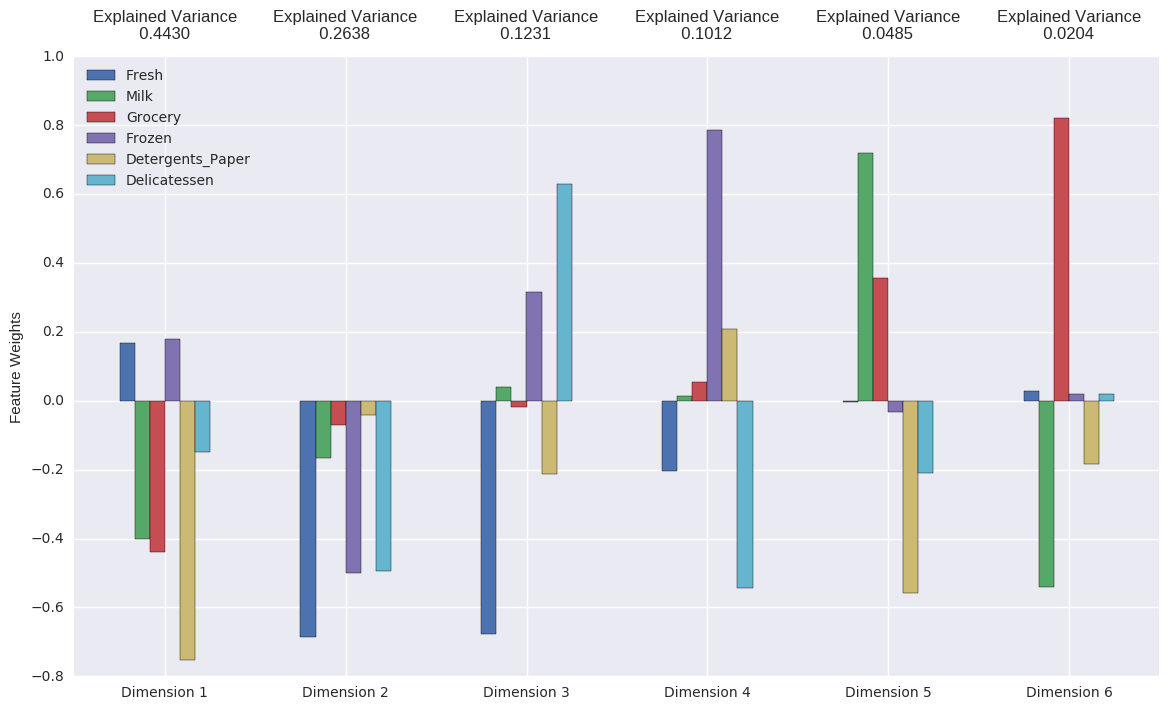

In [14]:
# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
from sklearn.decomposition import PCA
pca = PCA(n_components=6, random_state=42)
pca.fit(good_data)

# TODO: Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = vs.pca_results(good_data, pca)

In [15]:
print pca_results['Explained Variance'].cumsum()

Dimension 1    0.4430
Dimension 2    0.7068
Dimension 3    0.8299
Dimension 4    0.9311
Dimension 5    0.9796
Dimension 6    1.0000
Name: Explained Variance, dtype: float64


In [16]:
for i, x in enumerate(pca.transform(good_data)):
    if x[0] > 6: print(i, x)

(156, array([ 6.15377997, -0.04338886,  1.27529326, -2.31997916,  0.65672245,
       -0.24512092]))
(351, array([ 6.50250722, -0.08814371,  0.03590306, -0.64918784, -0.79446105,
        0.1048501 ]))


### Question 5
*How much variance in the data is explained* ***in total*** *by the first and second principal component? What about the first four principal components? Using the visualization provided above, discuss what the first four dimensions best represent in terms of customer spending.*  
**Hint:** A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the indivdual feature weights.

**Answer:**
*  The first and second components jointly explain a 70% of the variance.
*  The first four components explain 93% of the variance.
*  To explain what the principal components represent, we look for features with high absolute values for their loadings. The first four components can be interpreted as follows:
    1. Large negative weights on Deterget_Paper, Grocery amd Milk categories, this component describes the largest variance in the dataset, customers with a large negative value on this component will probably spend mostly on detergent grocery and milk. Customers with a positive value on this components will spend much less on detergent grocery and milk and a bit more on fresh and frozen products.
    2. The largest weightings are on Fresh, Frozen and Delicatessen, so customers with a large value of this component have little in common with the ones that are high in the first component.
    3. The loadings of Fresh and Delicatessen are large and of different sign, so customers with a high value for this principal component will probably spend a lot on Delicatessen and little or nothing on Fresh.
    4. The loadings of Frozen and Delicatessen are large and of different sign, so customers with a high value for this principal component will probably spend a lot on Frozen and little on Delicatessen.


### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with your initial interpretation of the sample points.

In [17]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,6.1538,-0.0434,1.2753,-2.3200,0.6567,-0.2451
1,-2.8734,-0.6774,0.1330,-0.1802,-0.0250,0.1224
2,-3.1493,3.6261,0.2868,0.7922,0.3404,-0.2045


### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, you will need to implement the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the results to `reduced_data`.
 - Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [18]:
# TODO: Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2, random_state=42).fit(good_data)

# TODO: Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# TODO: Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [19]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,6.1538,-0.0434
1,-2.8734,-0.6774
2,-3.1493,3.6261


## Visualizing a Biplot
A biplot is a scatterplot where each data point is represented by its scores along the principal components. The axes are the principal components (in this case `Dimension 1` and `Dimension 2`). In addition, the biplot shows the projection of the original features along the components. A biplot can help us interpret the reduced dimensions of the data, and discover relationships between the principal components and original features.

Run the code cell below to produce a biplot of the reduced-dimension data.

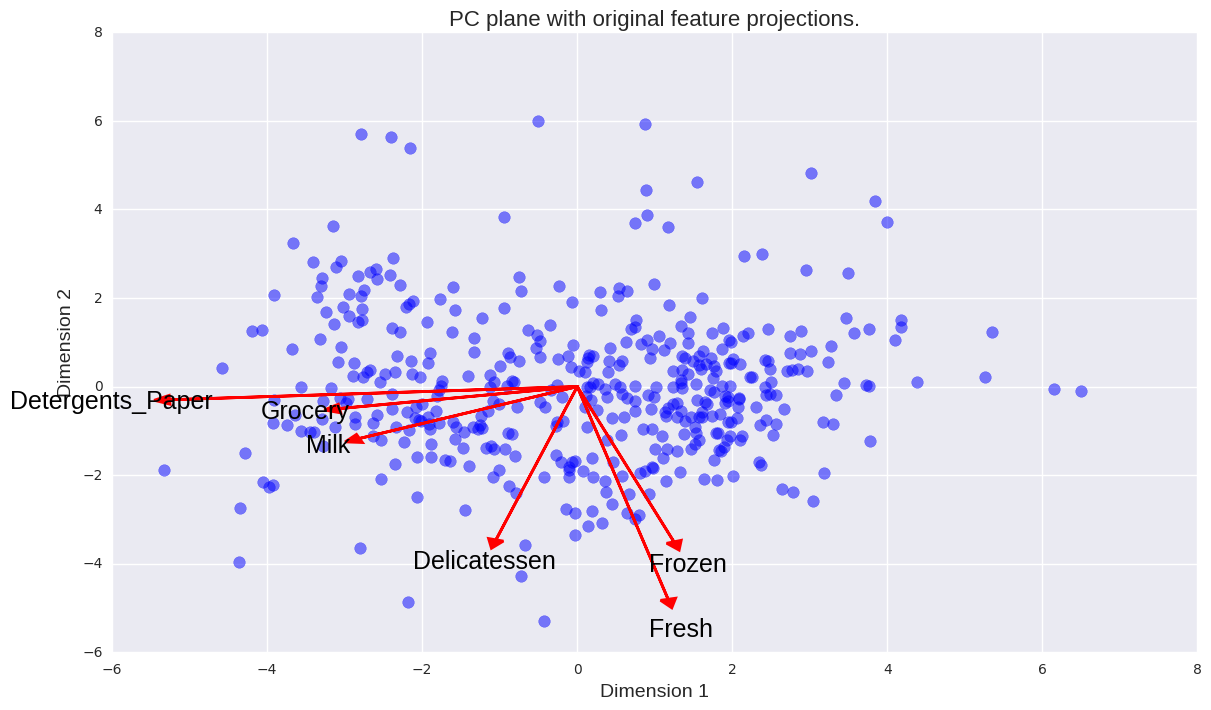

In [20]:
# Create a biplot
vs.biplot(good_data, reduced_data, pca)

### Observation

Once we have the original feature projections (in red), it is easier to interpret the relative position of each data point in the scatterplot. For instance, a point the lower right corner of the figure will likely correspond to a customer that spends a lot on `'Milk'`, `'Grocery'` and `'Detergents_Paper'`, but not so much on the other product categories. 

From the biplot, which of the original features are most strongly correlated with the first component? What about those that are associated with the second component? Do these observations agree with the pca_results plot you obtained earlier?

## Clustering

In this section, you will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. You will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6
*What are the advantages to using a K-Means clustering algorithm? What are the advantages to using a Gaussian Mixture Model clustering algorithm? Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?*

**Answer:**
* The k-means clustering method has the following advantages:
    * It can scale to a large number of data points.
    * Only one hyperparameter to optimize: the number of clusters
* The advantages of Mixture of Gaussians are as follows:
    * Soft assignment: give us the likelihood that a given data point belongs to each cluster.
    * It will not bias the clusters shapes to have a specific structure, for example it will not impose a hard separation line between clusters.
    * The method converges even if there are many points equidistant between two cluster centers.
    
Source:
http://scikit-learn.org/stable/modules/clustering.html


For this dataset, I choose the GMM manly for the following two reasons:
* The clusters do have a fair amount of overlap and, therefore it is not possible to achieve a perfect classification.
* The dataset is quite small and scalability is not an issue.

### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, you will need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import `sklearn.metrics.silhouette_score` and calculate the silhouette score of `reduced_data` against `preds`.
 - Assign the silhouette score to `score` and print the result.

In [21]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
def apply_cluster_model(n):
    # TODO: Apply your clustering algorithm of choice to the reduced data 
    clusterer = GaussianMixture(n_components=n, random_state=42)
    clusterer.fit(reduced_data)

    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds)
    return score

for n in range(2, 7):
    score = apply_cluster_model(n)
    print n, ':', score

2 : 0.421916846463
3 : 0.404248738241
4 : 0.293269564847
5 : 0.300456388725
6 : 0.326139450471


### Question 7
*Report the silhouette score for several cluster numbers you tried. Of these, which number of clusters has the best silhouette score?* 

**Answer:**
I tried varying the number of clusters from 2 to 6, the results are below:
* 2 : 0.421916846463
* 3 : 0.404248738241
* 4 : 0.293269564847
* 5 : 0.300456388725
* 6 : 0.326139450471

The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

The best silhouette score was obtained with 2 clusters.


In [22]:
n = 2
# TODO: Apply your clustering algorithm of choice to the reduced data 
clusterer = GaussianMixture(n_components=n, random_state=42)
clusterer.fit(reduced_data)

# TODO: Predict the cluster for each data point
preds = clusterer.predict(reduced_data)

# TODO: Find the cluster centers
centers = clusterer.means_

# TODO: Predict the cluster for each transformed sample data point
sample_preds = clusterer.predict(pca_samples)

### Cluster Visualization
Once you've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, you can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters. 

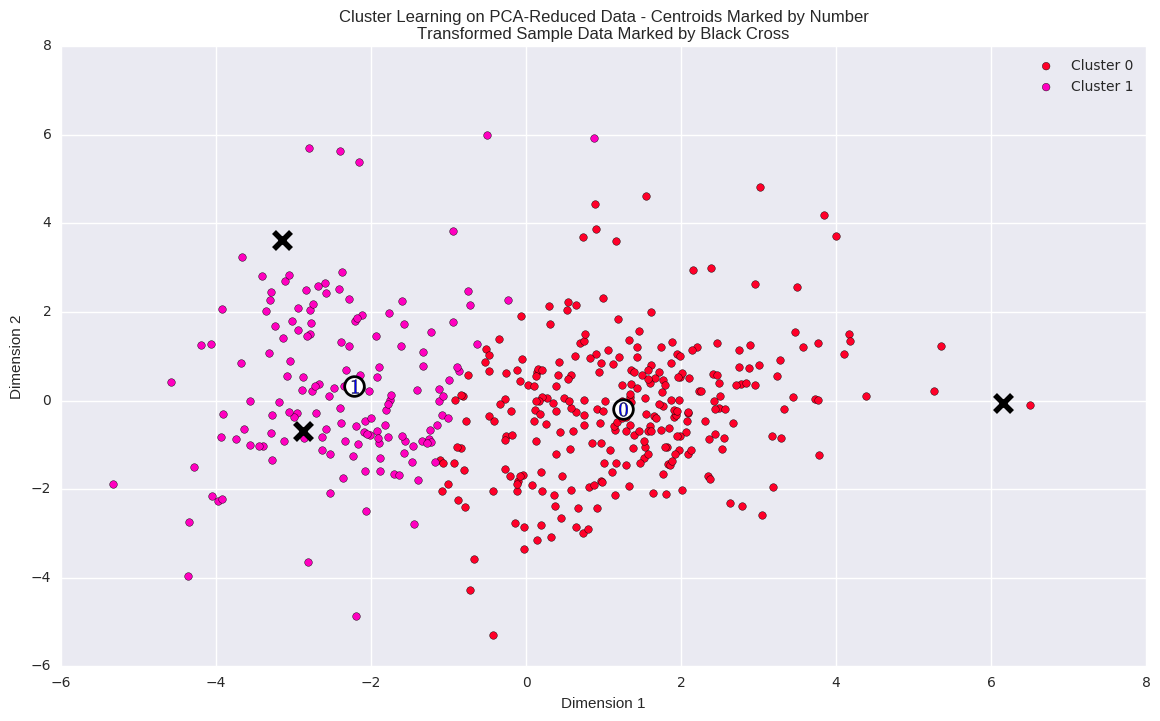

In [23]:
# Display the results of the clustering from implementation
vs.cluster_results(reduced_data, preds, centers, pca_samples)

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, you will need to implement the following:
 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.


In [24]:
# TODO: Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# TODO: Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,8953.0,2114.0,2765.0,2075.0,353.0,732.0
Segment 1,3552.0,7837.0,12219.0,870.0,4696.0,962.0


### Question 8
Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project. *What set of establishments could each of the customer segments represent?*  
**Hint:** A customer who is assigned to `'Cluster X'` should best identify with the establishments represented by the feature set of `'Segment X'`.

**Answer:**

Based on the statistics of the dataset (shown below), the segments can be assumed to represent the following types of establishments:

* Segment 0: Hotels-Cafes-Restaurants, because the cluster center shows a spending for Fresh and Frozen foods that is above the 50th percentile (median) and a spending for Groceries and Detergents that is well below the median.
* Segment 1: Retailers, because the cluster center shows a spending for Groceries and Detergents that is well above the 75th percentile and a spending in Fresh and Frozen that is below the median.


In [25]:
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Question 9
*For each sample point, which customer segment from* ***Question 8*** *best represents it? Are the predictions for each sample point consistent with this?*

Run the code block below to find which cluster each sample point is predicted to be.

First we attempt to visually compare the features of the sample points to those of the cluster_centers and try to guess the cluster to which each sample point belong:
* 0: Fresh spending is above the Frozen spending of segment 0 center, Grocery and Detergent spending is way below the center of cluster 0, what we can observe is that the center of segment 0 is *between* the center of cluster 1 and this sample point in the 3 dimensions compared, so the point is likely to belog to Segment 0.
* 1 and 2: The point is at the opposite end of the range from segment 0 (with the center of segment 1 located *between* the point and segment 0) in the dimensions Fresh and Grocery, so these pints are likely to belong in Segment 1.

In [26]:
display(samples)
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,12434,540,283,1092,3,2233
1,6006,11093,18881,1159,7425,2098
2,219,9540,14403,283,7818,156


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,8953.0,2114.0,2765.0,2075.0,353.0,732.0
Segment 1,3552.0,7837.0,12219.0,870.0,4696.0,962.0


In [27]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print "Sample point", i, "predicted to be in Cluster", pred

Sample point 0 predicted to be in Cluster 0
Sample point 1 predicted to be in Cluster 1
Sample point 2 predicted to be in Cluster 1


**Answer:**
* Sample point 0 : Cluster 1: Hotel, Cafe or Restaurant
* Sample point 1 : Cluster 1: Retailer
* Sample point 2 : Cluster 1: Retailer

The results of the clustering are 100% consistent with the predictions based on the distances to the clusters centers and also the speculation based on the dataset statistics made earlier in this notebook. 

## Conclusion

In this final section, you will investigate ways that you can make use of the clustered data. First, you will consider how the different groups of customers, the ***customer segments***, may be affected differently by a specific delivery scheme. Next, you will consider how giving a label to each customer (which *segment* that customer belongs to) can provide for additional features about the customer data. Finally, you will compare the ***customer segments*** to a hidden variable present in the data, to see whether the clustering identified certain relationships.

### Question 10
Companies will often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services to determine whether making that change will affect its customers positively or negatively. The wholesale distributor is considering changing its delivery service from currently 5 days a week to 3 days a week. However, the distributor will only make this change in delivery service for customers that react positively. *How can the wholesale distributor use the customer segments to determine which customers, if any, would react positively to the change in delivery service?*  
**Hint:** Can we assume the change affects all customers equally? How can we determine which group of customers it affects the most?


**Answer:**
* We need to decide how to measure 'positive reaction', for example we can define positive reaction interms of the increase or decrease of the monthly number of units purchased, seasonally adjusted.
* The experiment consists in offering the new delivery service to a small random sample of customers from each segment and leave the experiment running for one month.
* At the end of the month we compare the results of the treatment group against the control group for each segment and we can rank the segments according to their sensitivity to the offer.
* The main point to notice is that any test performed on the customers, including an A/B test, must take into account the fact that there are different customer segments. Mixing the segments may lead to undesirable results in the test.
* Alternatively, if there is no time to do A/B testing, a common sense approach is to assume that the customers segments that consume more Fresh and Frozen will derive more value out of the short delivery offer, because that means that they need to keep less inventory of these products that are either perishable or have a high energy cost to keep them frozen.

### Question 11
Additional structure is derived from originally unlabeled data when using clustering techniques. Since each customer has a ***customer segment*** it best identifies with (depending on the clustering algorithm applied), we can consider *'customer segment'* as an **engineered feature** for the data. Assume the wholesale distributor recently acquired ten new customers and each provided estimates for anticipated annual spending of each product category. Knowing these estimates, the wholesale distributor wants to classify each new customer to a ***customer segment*** to determine the most appropriate delivery service.  
*How can the wholesale distributor label the new customers using only their estimated product spending and the* ***customer segment*** *data?*  
**Hint:** A supervised learner could be used to train on the original customers. What would be the target variable?

**Answer:**
* Train a supervised learner on existing customers that takes as features the customer's product spending on each category and the label is the segment to which the customer belongs.

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

Run the code block below to see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, you will find the sample points are circled in the plot, which will identify their labeling.

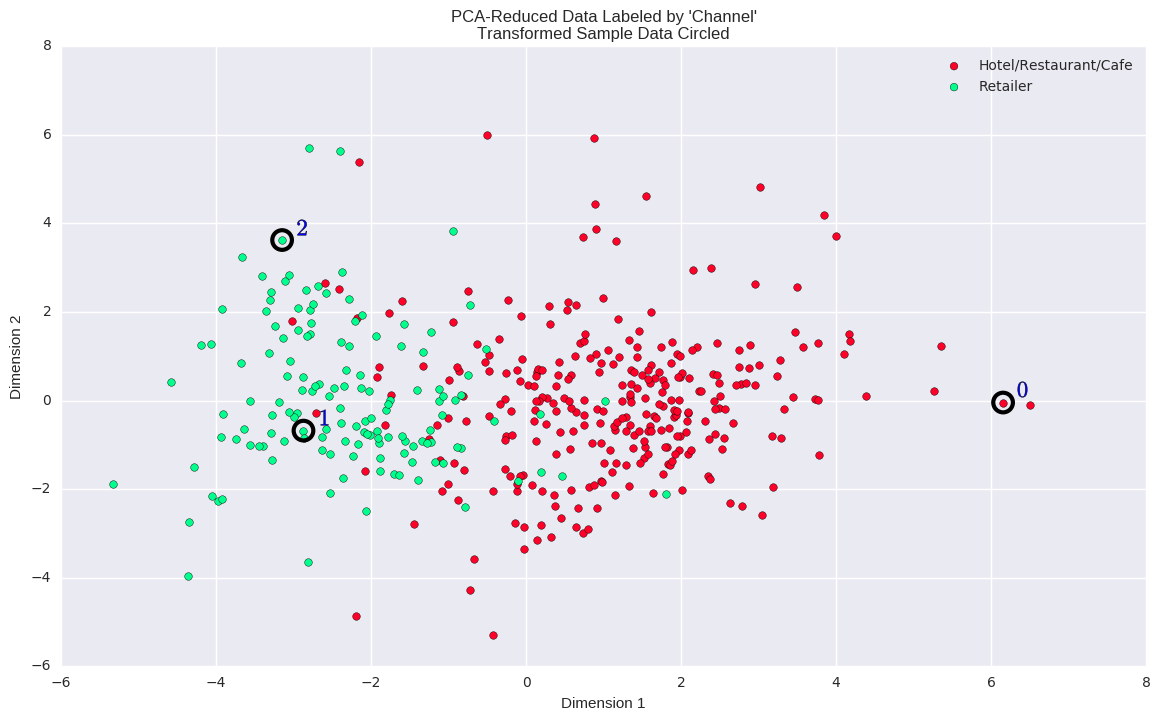

In [28]:
# Display the clustering results based on 'Channel' data
vs.channel_results(reduced_data, outliers, pca_samples)

### Question 12
*How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? Would you consider these classifications as consistent with your previous definition of the customer segments?*

**Answer:**
* The channel segmentation results are consistent with the customer segments obtained by  clustering customers acording to their sending by product category. Customer segment 1 corresponds to the 'Retailer' channel, and segment 0  would be clasified neatly in the HoReCa channel. We also observe a percentage of points that would have been miss-classified if we used the channel information istead of the clustering-bsed segmentation, so the alignment of channels and segments is ony approximate, not completely accurate.